In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
from sklearn.metrics import accuracy_score

import requests, zipfile, io, json
import os, glob
import shutil

print(tf.__version__)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

2.9.1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

# Get the tokenizer
tokenizer = info.features['text'].encoder

train_data, test_data = dataset['train'], dataset['test'], 

In [3]:
vocab_size = 7500
max_length = 32
embedding_dim = 64
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
SHUFFLE_SIZE=len(train_data) // 2
BATCH_SIZE = 128
EPOCHS = 50 
PATIENCE = 3
MONITOR = 'val_acc'

In [4]:
# Shuffle the training data
train_dataset = train_data.shuffle(SHUFFLE_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

print(type(train_dataset), type(test_dataset))


for i in train_dataset.take(1):
    print(i)

<class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'> <class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'>
(<tf.Tensor: shape=(128, 1344), dtype=int64, numpy=
array([[  62,   18,    4, ...,    0,    0,    0],
       [4875, 3273,   21, ...,    0,    0,    0],
       [  12,  689, 2094, ...,    0,    0,    0],
       ...,
       [ 249,    4, 4476, ...,    0,    0,    0],
       [  62,    9,    4, ...,    0,    0,    0],
       [ 173,   29, 1461, ...,    0,    0,    0]], dtype=int64)>, <tf.Tensor: shape=(128,), dtype=int64, numpy=
array([0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], dtype=int64

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, None, 96)         43392     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 96)         55680     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 96)               55680     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                3104      
                                                        

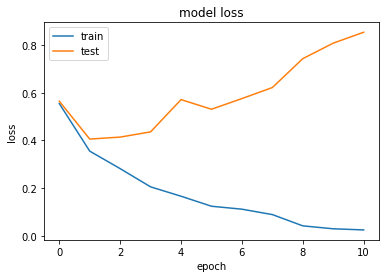

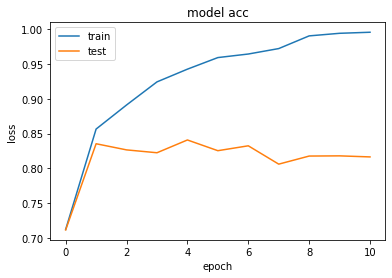

In [5]:
MODEL_NAME = './models/IMDB_Subwords_8k_LSTM_full_verse.h5'

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setup the training parameters
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Nadam(1e-3),
    metrics=['acc']
)

# Print the model summary
print(model.summary())

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-5)]
callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE*2, restore_best_weights=True)]

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_dataset,
    callbacks=callbacks
)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 64)         18816     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 64)         18816     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               18816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                      

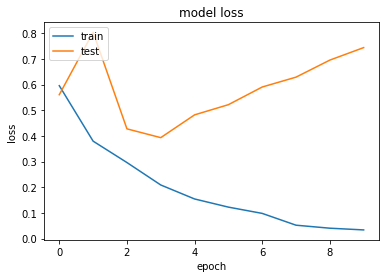

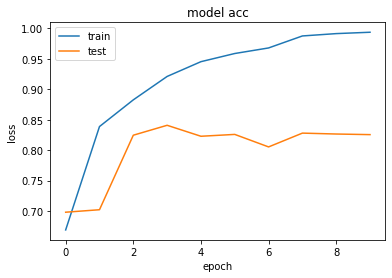

In [6]:
MODEL_NAME = './models/IMDB_Subwords_8k_GRU_full_verse.h5'

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setup the training parameters
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Nadam(1e-3),
    metrics=['acc']
)

# Print the model summary
print(model.summary())

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-5)]
callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE*2, restore_best_weights=True)]

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_dataset,
    callbacks=callbacks
)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
MODEL_NAME = './models/IMDB_Subwords_8k_CNN_full_verse.h5'

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters=48, kernel_size=5, activation='relu', padding='causal'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setup the training parameters
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Nadam(1e-3),
    metrics=['acc']
)

# Print the model summary
print(model.summary())

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-5)]
callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE*2, restore_best_weights=True)]

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_dataset,
    callbacks=callbacks
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          523840    
                                                                 
 conv1d (Conv1D)             (None, None, 48)          15408     
                                                                 
 global_max_pooling1d (Globa  (None, 48)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 32)                1568      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 540,849
Trainable params: 540,849
Non-trainable params: 0
________________________________________________

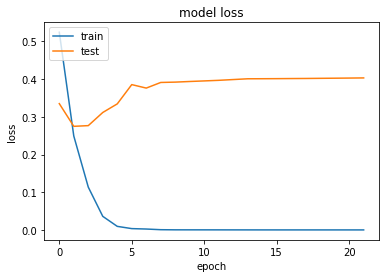

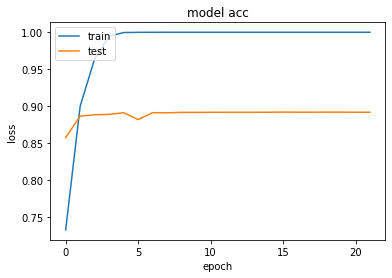

In [8]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()